# Recurrent Neural Networks

## Case Study | Sentiment Analysis with IMDB Reviews

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

## Loading the Dataset from TensorFlow

TensorFlow offers several popular datasets, which can directly be
loaded from the tensorflow_datasets API. The load() function of the
tensorflow_datasets API returns two objects: (i) a dictionary containing
train, test, and unlabeled sets and (ii) information and other relevant
objects regarding the IMDB reviews dataset.

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k',with_info=True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5X2TN9/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5X2TN9/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete5X2TN9/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'unsupervised': <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

## Understanding the Bag-of-Word Concept: Text Encoding and Decoding

A bag of words is a representation of text that describes the occurrence of words within a document.This representation is created based on
a vocabulary of words. In our dataset, reviews are encoded using a
vocabulary of 8185 words. We can access the encoder via the “info” object
that we created earlier.

In [ ]:
info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

In [ ]:
# Using info we can load the encoder which converts text to bag of words
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


By using this encoder, we can encode new reviews:

In [ ]:
# encode a brand new comment with encode function
review = 'Terrible Movie!.'
encoded_review = encoder.encode(review)
print("Encoded review is {}".format(encoded_review))

Encoded review is [3585, 3194, 7785, 7962, 7975]


We can also decode an encoded review as follows

In [ ]:
# easily decode an encoded review with decode function
original_review = encoder.decode(encoded_review)
print('The original review is "{}"'.format(original_review))

The original review is "Terrible Movie!."


## Preparing the Dataset


We already saved our reviews in the “dataset” object, which is a dictionary
with three keys: (i) train, (ii) test, and (iii) unlabeled. By using these keys,
we will split our train and test sets

In [ ]:
# split our dataset dictionary with the relevant keys
train_dataset, test_dataset = dataset['train'], dataset['test']

We also need to shuffle our dataset to avoid any bias and pad our
reviews so that all of them are in the same length. We need to select a large
buffer size so that we can have a well-mixed train dataset. In addition, to
avoid the excessive computational burden, we will limit our sequence
length to 64.

In [ ]:
Buffer_size = 10000
Batch_size = 64
train_dataset = train_dataset.shuffle(Buffer_size)
train_dataset = train_dataset.padded_batch(Batch_size)
test_dataset = test_dataset.padded_batch(Batch_size)

Padding is a useful method to encode sequence data into
contiguous batches. To be able to fit all the sequences to a defined
length, we must pad or truncate some sequences in our dataset.

## Building the Recurrent Neural Network

Now that our train and test datasets are ready to be fed into the model, we
can start building our RNN model with LSTM units.

### Imports for model building

We use Keras Sequential API to build our models. We also need Dense,
Embedding, Bidirectional, LSTM, and Dropout layers to build our RNN
model. We also need to import Binary Crossentropy as our loss function
since we use binary classification to predict whether a comment is
negative or positive. Finally, we use Adam optimizer to optimize our
weights with backpropagation1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,Embedding,Bidirectional,Dropout,LSTM)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

## Create the Model and Fill It with Layers

We use an Encoding layer, two LSTM layers wrapped in Bidirectional layers,
two Dense layers, and a Dropout layer. We start with an embedding layer,
which converts the sequences of word indices to sequences of vectors

An embedding layer stores one vector per word. Then, we add two LSTM layers
wrapped in Bidirectional layers. Bidirectional layers propagate the input back
and forth through the LSTM layers and then concatenate the output, which
is useful to learn long-range dependencies. Then, we add to one Dense layer
with 64 neurons to increase the complexity, a Dropout layer to fight overfitting.
Finally, we add a final Dense layer to make a binary prediction

In [ ]:
model = Sequential()
model.add(Embedding(encoder.vocab_size, 64))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

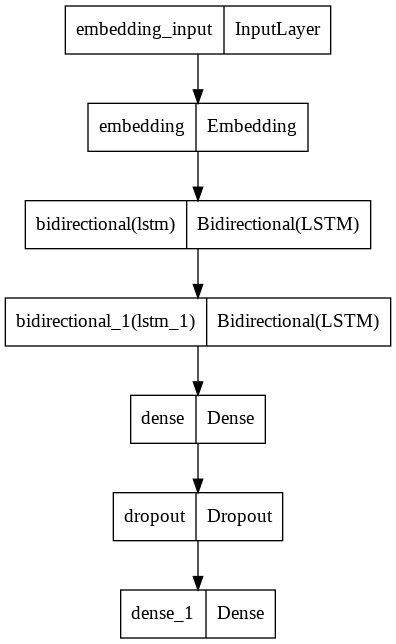

In [ ]:
tf.keras.utils.plot_model(model)

## Compiling and Fitting the Model

Now that we build an empty model, it is time to configure the loss function,
optimizer, and performance metrics

In [ ]:
model.compile(loss=BinaryCrossentropy(from_logits=True),
            optimizer=Adam(1e-4),
            metrics=['accuracy'])

Our data and model are ready for training. We can use model.fit()
function to train our model. Around 10 epochs would be more than
enough for training our sentiment analysis model, which may take around
30 minutes. 

In [ ]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 244s 593ms/step - loss: 0.6546 - accuracy: 0.5540 - val_loss: 0.4493 - val_accuracy: 0.7896
Epoch 2/10
391/391 [==============================] - 230s 585ms/step - loss: 0.3600 - accuracy: 0.8528 - val_loss: 0.3759 - val_accuracy: 0.8411
Epoch 3/10
391/391 [==============================] - 231s 589ms/step - loss: 0.2558 - accuracy: 0.9066 - val_loss: 0.3457 - val_accuracy: 0.8557
Epoch 4/10
391/391 [==============================] - 232s 593ms/step - loss: 0.2066 - accuracy: 0.9290 - val_loss: 0.3665 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 229s 585ms/step - loss: 0.1710 - accuracy: 0.9440 - val_loss: 0.3969 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 232s 590ms/step - loss: 0.1541 - accuracy: 0.9522 - val_loss: 0.3975 - val_accuracy: 0.8516
Epoch 7/10
391/391 [==============================] - 230s 587ms/step - loss: 0.1307 - accuracy: 0.9610 - val_loss: 0.5387 -

## Evaluating the Model

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test_loss:{}'.format(test_loss))
print('Test accuracy:{}'.format(test_acc))

391/391 [==============================] - 91s 232ms/step - loss: 0.5785 - accuracy: 0.8359
Test_loss:0.5784654021263123
Test accuracy:0.835919976234436


Use history object to plot the performance measures

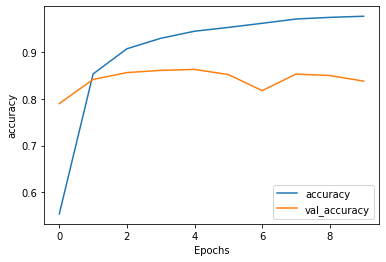

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
plot_graphs(history, 'accuracy')

## Making new predictions


Now that we trained our RNN model, we can make new sentiment
predictions from the reviews our model has never seen before. Since we
encoded and pad our train and test set, we have to process new reviews
the same way. Therefore, we need a padder and an encoder

In [ ]:
def review_padding(encoded_review, padding_size):
    zeros = [0]*(padding_size - len(encoded_review))
    encoded_review.extend(zeros)
    return encoded_review

We also need an encoder function that would encode and process our
review to feed into our trained model.

In [ ]:
def review_encoder(review):
    encoded_review = review_padding(encoder.encode(review),64)
    encoded_review = tf.cast(encoded_review, tf.float32)
    return tf.expand_dims(encoded_review, 0)

In [ ]:
fight_club_review = 'It has some cliched moments, even for its time, but FIGHT CLUB is an awesome film. I have watched it about 100 times in the past 20 years. It never gets old. It is hard to discuss this film without giving things away but suffice it to say, it is a great thriller with some intriguing twists.'

In [ ]:
model.predict(review_encoder(fight_club_review))

array([[4.44071]], dtype=float32)